In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [3]:
from __future__ import print_function
from numpy import *
from scipy import *
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import scipy as sp


import seawater
import datetime as dt
""
from salishsea_tools import (
    nc_tools,
    viz_tools,
    geo_tools,
    tidetools
)

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.style.use('seaborn-whitegrid')
import netCDF4 as nc

import cmocean as cm
import glob
import sys
sys.path.append('/data/tjarniko/mocsy')
sys.path.append('/data/tjarniko/MEOPAR/at3/notebooks/carbon_dev/CCCmaDEV/CCCma_src')
import mocsy
import CCCma
import CCCma_stations as cs
from matplotlib import reload
import arrow
import gsw
%matplotlib inline

import xarray as xr
from datetime import datetime
from salishsea_tools import grid_tools, viz_tools


/home/tjarniko/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## NCs related to this notebook

    OmA_2015.nc
    OmA_horizon_2015.nc

/home/tjarniko/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:6461: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/home/tjarniko/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:6461: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


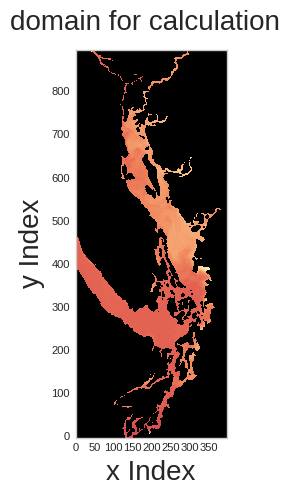

In [4]:
t_nc = nc.Dataset('/results2/SalishSea/nowcast-green.201806/01jan18/SalishSea_1h_20180101_20180101_grid_T.nc')
surfdat_1 = t_nc.variables['votemper'][0,0,:,:]

fig, ax = plt.subplots(1, 1, figsize=(5, 5), sharey=True)
cmap = cm.cm.matter
tplt = np.ma.masked_values(surfdat_1[:,:],0)
v_min = 2000
v_max = 2000

viz_tools.set_aspect(ax)
mesh = ax.pcolormesh(tplt, cmap=cm.cm.matter, vmin=0, vmax=20)
viz_tools.plot_land_mask(ax, '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')


ax.set_xlabel('x Index', fontsize = 20 )
ax.set_ylabel('y Index', fontsize = 20 )

#pat = patches.Rectangle((20,0),398-20,898-20,linewidth=2,edgecolor='g',facecolor='none')
#ax.add_patch(pat)

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
# cmap.set_bad('red')
plt.suptitle('domain for calculation',fontsize=20)


In [5]:
test_OmA = np.random.rand(40,898,398) +1 
t_nc = nc.Dataset('/results2/SalishSea/nowcast-green.201806/01jan18/SalishSea_1h_20180101_20180101_grid_T.nc')
depths = (t_nc['deptht'][:])


days_in = 365
depth_broad = np.zeros([days_in,40,898,398])
depth_broad2 = np.zeros([days_in,898,398])
depth_broad3 = np.zeros([40,898,398])
depth_broad4 = np.zeros([898,398])

for i in range(0,40):
    #depth_broad2[:] = depths[i]
    depth_broad4[:] = depths[i]
    #depth_broad[:,i,:,:] = depth_broad2
    depth_broad3[i,:,:] = depth_broad4


In [ ]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx], idx

def find_oma_depths_filtered(Omega_A_ar):
    oma_depths = np.zeros([898,398])
    for i in range(0,898):
        for j in range(0,398):
            t_slice = Omega_A_ar[:,i,j]
            val, idx = find_nearest(t_slice,1)
            oma_depths[i,j] = zlevels[idx]

    return oma_depths  

def find_oma_depths_via_amax(Omega_A_ar):
    #subtract 1 to find values close to sat. horizon.
    oma_close_to_1 = np.abs(Omega_A_ar[:,:,:] - 1)
    oma_depths = np.zeros([898,398])
    depth_inds = np.argmin(oma_close_to_1, axis=0)
    for i in range(0,898):
        for j in range(0,398):
            oma_depths[i,j] = zlevels[depth_inds[i,j]]
            
    return oma_depths

def find_oma_depths_via_amax_2(Omega_A_ar):
    #subtract 1 to find values close to sat. horizon.
#     oma_close_to_1 = np.abs(Omega_A_ar[:,:,:] - 1)
#     oma_depths = np.zeros([898,398])
    depth_inds = np.argmax(Omega_A_ar<1, axis=0)
    for i in range(0,898):
        for j in range(0,398):
            test_slice = Omega_A_ar[:,i,j]
            if np.min(w) > 1:
                oma_depths[i,j] = np.nan
            else:
                oma_depths[i,j] = zlevels[depth_inds[i,j]]
            
    return oma_depths

def find_oma_depths_via_susan(Omega_A_ar,tmask):
    depthindex = np.argmax(Omega_A_ar<1, axis=0)
    maxsal = np.amax(Omega_A_ar, axis=0)<1
    t_depths = np.ma.array(depthindex, mask=(1 - (tmask[0] * maxsal)));
    oma_depths = np.zeros([898,398])
    for i in range(0,898):
        for j in range(0,398):
            if np.ma.is_masked(t_depths[i,j]):
                oma_depths[i,j] = np.nan
            else:
                oma_depths[i,j] = zlevels[t_depths[i,j]]
    
    return oma_depths

In [ ]:
OmA = nc.Dataset('OmA_2015.nc')
BR_omA = OmA['model_output']['OmAr_pi']
PI_omA = OmA['model_output']['OmAr_br']

tmask = nc.Dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc')['tmask'][0]
t_nc = nc.Dataset('/results2/SalishSea/nowcast-green.201806/01jan18/SalishSea_1h_20180101_20180101_grid_T.nc')
zlevels = (t_nc['deptht'][:])

oma_d_PI = np.zeros([365,898,398])
oma_d_BR = np.zeros([365,898,398])
for day in range(0,365):
    print(day)
    OmA_BR_test = BR_omA[day,:,:,:]
    OmA_PI_test = PI_omA[day,:,:,:]
    
    oma_dep_PI = find_oma_depths_via_susan(OmA_PI_test,tmask)
    oma_dep_BR = find_oma_depths_via_susan(OmA_BR_test,tmask)
    oma_d_PI[day,:,:] = oma_dep_PI
    oma_d_BR[day,:,:] = oma_dep_BR

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80


In [ ]:
w = np.array([2,4,3])

np.min(w)

In [ ]:
omega_test = np.array([[2,2],[1.2,0.9],[0.9,1.1]])
print(omega_test)
print(np.shape(omega_test))

depth_inds = np.argmax(omega_test<1, axis=0)
print(depth_inds)
# oma_depths = np.zeros([1,2])
# for i in range(0,2):
#     oma_depths[0,i] = depth_inds[i,j]


In [ ]:
# import timeit
# start_time = timeit.default_timer()
# print(start_time)
# oma_depths = find_oma_depths_filtered(test_OmA)
# elapsed = timeit.default_timer() - start_time
# print(elapsed)

# import timeit
# start_time = timeit.default_timer()
# print(start_time)
# oma_depths_2 = find_oma_depths_via_amax(test_OmA)
# elapsed = timeit.default_timer() - start_time
# print(elapsed)

In [ ]:
# t_nc = nc.Dataset('/results2/SalishSea/nowcast-green.201806/01jan18/SalishSea_1h_20180101_20180101_grid_T.nc')
# surfdat_1 = t_nc.variables['votemper'][0,0,:,:]

# fig, ax = plt.subplots(1, 1, figsize=(5, 5), sharey=True)
# cmap = cm.cm.deep
# tplt = oma_depths
# v_min = 2000
# v_max = 2000

# viz_tools.set_aspect(ax)
# mesh = ax.pcolormesh(tplt, cmap=cm.cm.matter, vmin=0, vmax=400)
# viz_tools.plot_land_mask(ax, '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')


# ax.set_xlabel('x Index', fontsize = 20 )
# ax.set_ylabel('y Index', fontsize = 20 )

# #pat = patches.Rectangle((20,0),398-20,898-20,linewidth=2,edgecolor='g',facecolor='none')
# #ax.add_patch(pat)

# plt.xticks(fontsize=8)
# plt.yticks(fontsize=8)
# # cmap.set_bad('red')
# plt.suptitle('domain for calculation',fontsize=20)


In [ ]:
Oma_hor = nc.Dataset('OmA_horizon_2015_amax2attempt.nc')

OmArHORIZON_pi = Oma_hor['model_output']['OmArHORIZON_pi'][90,:,:]
OmArHORIZON_br = Oma_hor['model_output']['OmArHORIZON_br'][90,:,:]



In [ ]:
OmA_h_janfeb_pi = np.array(Oma_hor['model_output']['OmArHORIZON_pi'][0:60,:,:])
OmA_h_dec_pi = np.array(Oma_hor['model_output']['OmArHORIZON_pi'][364-60:-1,:,:])
OmA_h_winter_pi = np.concatenate([OmA_h_janfeb_pi,OmA_h_dec_pi])

OmA_h_janfeb_br = np.array(Oma_hor['model_output']['OmArHORIZON_br'][0:60,:,:])
OmA_h_dec_br = np.array(Oma_hor['model_output']['OmArHORIZON_br'][364-60:-1,:,:])
OmA_h_winter_br = np.concatenate([OmA_h_janfeb_br,OmA_h_dec_br])

#midmay to sept 1 
OmA_h_summer_pi = np.array(Oma_hor['model_output']['OmArHORIZON_pi'][134:243,:,:])
OmA_h_summer_br = np.array(Oma_hor['model_output']['OmArHORIZON_br'][134:243,:,:])



OmA_h_winter_mean_br = np.mean(OmA_h_winter_br,axis = 0)
OmA_h_winter_mean_pi = np.mean(OmA_h_winter_pi,axis = 0)
OmA_h_summer_mean_br = np.mean(OmA_h_summer_br,axis = 0)
OmA_h_summer_mean_pi = np.mean(OmA_h_summer_pi,axis = 0)


print(np.shape(OmA_h_winter_mean_br))

In [ ]:
mask = np.zeros([40,898,398])
mask[:] = 4
for y in range(0,898):
    for x in range(0,398):
        #jdf
        if  (x <200) & (y>220) & (y<500) :
            mask[:,y,x] = 1
            #nsog
        if  (y >= 550) :
            mask[:,y,x] = 2
            # s sog
        if (x> 150) & (y>310) & (y<550) :
            mask[:,y,x] = 3
            
bathy = nc.Dataset('/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc')
land_mask = bathy['Bathymetry'][:]
print(land_mask[0,0])

land_mask2 = np.zeros([898,398])
land_mask2[land_mask>0] = 1
print(land_mask2[0,0])

new_mask = np.zeros([40,898,398])

for i in range(0,40):
    new_mask[i,:,:] = land_mask2
    
print('*')
print(new_mask[0,0,0])

mask[new_mask == 0] = 0
print(mask[0,0,0])

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
viz_tools.set_aspect(ax)
mesh = ax.pcolormesh(mask[0,:,:], cmap=cm.cm.dense)
fig.colorbar(mesh)
plt.suptitle('MASK of regions, input file',fontsize=20)


OmA_h_winter_mean_br[mask[0,:,:] ==0 ] = np.nan
OmA_h_winter_mean_pi[mask[0,:,:] ==0 ] = np.nan
OmA_h_summer_mean_br[mask[0,:,:] ==0 ] = np.nan
OmA_h_summer_mean_pi[mask[0,:,:] ==0 ] = np.nan


In [ ]:
OmA_h_summer_mean_pi[0,0]

In [ ]:
fig = plt.figure(figsize=(12*1.8,10.5*1.8))

ax1 = fig.add_subplot(2,3,1)
cmap = cm.cm.deep
tplt = OmA_h_winter_mean_pi
viz_tools.set_aspect(ax1)
mesh = ax1.pcolormesh(tplt, cmap=cm.cm.deep, vmin=0, vmax=150)
viz_tools.plot_land_mask(ax1, '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc', color = 'burlywood')
cbar = plt.colorbar(mesh)
ax1.set_title('Preindustrial - Winter $\Omega_A$ sat. depth ', fontsize = 22)
plt.xticks([])
plt.yticks([])
cbar.ax.tick_params(labelsize=15)
cbar.set_label('$\Omega_A$ saturation horizon (m)', fontsize = 20)

ax2 = fig.add_subplot(2,3,2)
cmap = cm.cm.deep
tplt = OmA_h_winter_mean_br
viz_tools.set_aspect(ax2)
mesh = ax2.pcolormesh(tplt, cmap=cm.cm.deep, vmin=0, vmax=150)
viz_tools.plot_land_mask(ax2, '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc', color = 'burlywood')
cbar = plt.colorbar(mesh)
ax2.set_title('Present-day - Winter $\Omega_A$ sat. depth ', fontsize = 22)
plt.xticks([])
plt.yticks([])
cbar.ax.tick_params(labelsize=15)
cbar.set_label('$\Omega_A$ saturation horizon (m)', fontsize = 20)
 
ax3 = fig.add_subplot(2,3,3)
cmap = cm.cm.balance
tplt = OmA_h_winter_mean_pi - OmA_h_winter_mean_br
viz_tools.set_aspect(ax3)
mesh = ax3.pcolormesh(tplt, cmap=cm.cm.balance, vmin=-40, vmax=40)
viz_tools.plot_land_mask(ax3, '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc', color = 'burlywood')
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar(mesh)
cbar.ax.tick_params(labelsize=15)
ax3.set_title('Preindustrial - Present-day Winter $\Omega_A$ shoaling', fontsize = 22)
cbar.set_label('$\Omega_A$ saturation horizon shoaling (m)', fontsize = 20)


ax1 = fig.add_subplot(2,3,4)
cmap = cm.cm.deep
tplt = OmA_h_summer_mean_pi
viz_tools.set_aspect(ax1)
mesh = ax1.pcolormesh(tplt, cmap=cm.cm.deep, vmin=0, vmax=150)
viz_tools.plot_land_mask(ax1, '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc', color = 'burlywood')
cbar = plt.colorbar(mesh)

ax1.set_title('Preindustrial - Summer $\Omega_A$ sat. depth ', fontsize = 22)
plt.xticks([])
plt.yticks([])
cbar.ax.tick_params(labelsize=15)
cbar.set_label('$\Omega_A$ saturation horizon (m)', fontsize = 20)

ax2 = fig.add_subplot(2,3,5)
cmap = cm.cm.deep
tplt = OmA_h_summer_mean_br
viz_tools.set_aspect(ax2)
mesh = ax2.pcolormesh(tplt, cmap=cm.cm.deep, vmin=0, vmax=150)
viz_tools.plot_land_mask(ax2, '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc', color = 'burlywood')
cbar = plt.colorbar(mesh)
ax2.set_title('Present-day - Summer $\Omega_A$ sat. depth ', fontsize = 22)
plt.xticks([])
plt.yticks([])
cbar.ax.tick_params(labelsize=15)
cbar.set_label('$\Omega_A$ saturation horizon (m)', fontsize = 20)

ax3 = fig.add_subplot(2,3,6)
cmap = cm.cm.balance
tplt = OmA_h_summer_mean_pi - OmA_h_summer_mean_br
viz_tools.set_aspect(ax3)
mesh = ax3.pcolormesh(tplt, cmap=cm.cm.balance, vmin=-40, vmax=40)
viz_tools.plot_land_mask(ax3, '/data/tjarniko/MEOPAR/NEMO-forcing/grid/bathy_meter_SalishSea2.nc', color = 'burlywood')
ax3.set_title('Preindustrial - Present-day Summer $\Omega_A$ shoaling', fontsize = 22)
cbar = plt.colorbar(mesh)
plt.xticks([])
plt.yticks([])
cbar.ax.tick_params(labelsize=15)
cbar.set_label('$\Omega_A$ saturation horizon shoaling (m)', fontsize = 20)

# cmap.set_bad('red')
# cmap.set_bad('red')

plt.tight_layout()

In [ ]:
reg_mask = np.where(surf_mask == 1)
t = OmA_h_summer_mean_pi[reg_mask]
print(np.size(t))

In [ ]:
w = np.array([2,2,2])
if np.min(w) >1:
    depth_inds = nan
else:
    depth_inds = np.argmax(w<1, axis=0)
print(depth_inds)

In [ ]:
reg = ['JdF','N. Sog','S. Sog','Haro']
for i in range(1,5):
    
    surf_mask = mask[0,:,:]
    print(np.shape(surf_mask))
    
    reg_mask = np.where(surf_mask == i)
    print('')
    print(reg[i-1])
    summer_shoal = (OmA_h_summer_mean_pi - OmA_h_summer_mean_br)
    print('average summer sat. hor. (PI): ', np.nanmean(OmA_h_summer_mean_pi[reg_mask]))
    print('average summer sat. hor (BR): ', np.nanmean(OmA_h_summer_mean_br[reg_mask]))

    print('PI-BR shoaling summer: ', np.nanmean(summer_shoal[reg_mask]))
    winter_shoal = (OmA_h_winter_mean_pi - OmA_h_winter_mean_br)
    print('average winter sat. hor. (PI): ', np.nanmean(OmA_h_winter_mean_pi[reg_mask]))
    print('average winter sat. hor (BR): ', np.nanmean(OmA_h_winter_mean_br[reg_mask]))
    
    print('PI-BR shoaling winter: ', np.nanmean(winter_shoal[reg_mask]))
    


In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7, 7), sharey=True)
ax1.hist(OmA_h_summer_mean_pi,bins = tbins) 
ax1.set_title("Summer - preindustrial") 

ax2.hist(OmA_h_winter_mean_pi,bins = tbins) 
ax2.set_title("Winter - preindustrial") 

ax3.hist(OmA_h_summer_mean_br,bins = tbins) 
ax3.set_title("Summer - baserun") 

ax4.hist(OmA_h_winter_mean_br,bins = tbins) 
ax4.set_title("Winter - baserun") 
plt.suptitle('Full Domain', fontsize = 20)
plt.show()

In [ ]:
i = 1
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7, 7), sharey=True)
reg_mask = np.where(surf_mask == i)
ax1.hist(OmA_h_summer_mean_pi[reg_mask],bins = tbins) 
ax1.set_title("Summer - preindustrial") 

ax2.hist(OmA_h_winter_mean_pi[reg_mask],bins = tbins) 
ax2.set_title("Winter - preindustrial") 

ax3.hist(OmA_h_summer_mean_br[reg_mask],bins = tbins) 
ax3.set_title("Summer - baserun") 

ax4.hist(OmA_h_winter_mean_br[reg_mask],bins = tbins) 
ax4.set_title("Winter - baserun") 
plt.suptitle(reg[i-1], fontsize = 20)
plt.show()

In [ ]:
i = 2
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7, 7), sharey=True)
reg_mask = np.where(surf_mask == i)
ax1.hist(OmA_h_summer_mean_pi[reg_mask],bins = tbins) 
ax1.set_title("Summer - preindustrial") 

ax2.hist(OmA_h_winter_mean_pi[reg_mask],bins = tbins) 
ax2.set_title("Winter - preindustrial") 

ax3.hist(OmA_h_summer_mean_br[reg_mask],bins = tbins) 
ax3.set_title("Summer - baserun") 

ax4.hist(OmA_h_winter_mean_br[reg_mask],bins = tbins) 
ax4.set_title("Winter - baserun") 
plt.suptitle(reg[i-1], fontsize = 20)
plt.show()

In [ ]:
i = 4
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7, 7), sharey=True)
reg_mask = np.where(surf_mask == i)
ax1.hist(OmA_h_summer_mean_pi[reg_mask],bins = tbins) 
ax1.set_title("Summer - preindustrial") 

ax2.hist(OmA_h_winter_mean_pi[reg_mask],bins = tbins) 
ax2.set_title("Winter - preindustrial") 

ax3.hist(OmA_h_summer_mean_br[reg_mask],bins = tbins) 
ax3.set_title("Summer - baserun") 

ax4.hist(OmA_h_winter_mean_br[reg_mask],bins = tbins) 
ax4.set_title("Winter - baserun") 
plt.suptitle(reg[i-1], fontsize = 20)
plt.show()

In [ ]:
i = 3
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(7, 7), sharey=True)
reg_mask = np.where(surf_mask == i)
ax1.hist(OmA_h_summer_mean_pi[reg_mask],bins = tbins) 
ax1.set_title("Summer - preindustrial") 

ax2.hist(OmA_h_winter_mean_pi[reg_mask],bins = tbins) 
ax2.set_title("Winter - preindustrial") 

ax3.hist(OmA_h_summer_mean_br[reg_mask],bins = tbins) 
ax3.set_title("Summer - baserun") 

ax4.hist(OmA_h_winter_mean_br[reg_mask],bins = tbins) 
ax4.set_title("Winter - baserun") 
plt.suptitle(reg[i-1], fontsize = 20)
plt.show()